In [1]:
!git clone https://github.com/shub2022/Optimizers_DLS

Cloning into 'Optimizers_DLS'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 62 (delta 12), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (62/62), 16.69 KiB | 5.56 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [2]:
ls

Optimizers_DLS/  sample_data/


In [3]:
%cd Optimizers_DLS/

/content/Optimizers_DLS


In [4]:
%cd data/

/content/Optimizers_DLS/data


In [5]:
from csv_data import HousePricesDatasetWrapper

wrapper = HousePricesDatasetWrapper()
train_data, valid_data, test_data = wrapper.get_flat_datasets()

/usr/local/lib/python3.10/dist-packages
/usr/local/lib/python3.10/dist-packages/house_prices.csv


Downloading...
From: https://drive.google.com/uc?export=download&id=1eWeeYlxNatpXQSsiFwQg2HJeYCTJNj9Z
To: /usr/local/lib/python3.10/dist-packages/house_prices.csv
100%|██████████| 71.2k/71.2k [00:00<00:00, 38.8MB/s]


In [ ]:
# Show the train predictors
train_data[0][:2]

In [ ]:
# Show the train target
train_data[1][:2]

In [17]:
# Defining a class for creating Dense layers
import math
import numpy as np

class Dense():
  def __init__(self,input_size,output_size,activation=True,seed=0): # Activation always set as true, set seed as zero for initializing random weight matrices
    self.add_activation=activation
    self.hidden=None
    self.prev_hidden=None # Hidden and previous hidden will be eventually used for creating a "Fully Connected Dense Neural Network"
    # Will be using ReLu activation function hence using LeCun Normal intializing strategy for weight matrices
    np.random.seed(seed)
    k=math.sqrt(1/input_size)
    self.weights = (k**2) * np.random.randn(input_size,output_size) + 0

    # Intializing bias to 1
    self.bias=np.ones((1,output_size))

  # Defining forward propagation function
  def forward(self,x):
    self.prev_hidden=x.copy()
    x=np.matmul(x,self.weights) + self.bias

    if self.add_activation:
      x=np.maximum(x,0)

    self.hidden=x.copy()
    return x

  # Defining the backward propagation function
  def backward(self,grad): # Grad is the gradient for the current layer
    # Undo ing the activation function (ReLu)
    if self.add_activation:
      grad = np.multiply(grad, np.heaviside(self.hidden, 0))

    # Calculating the weight and bias gradient
    w_grad=self.prev_hidden.T @ grad
    b_grad = np.mean(grad, axis=0)
    param_grads = [w_grad, b_grad]

    grad= grad @ self.weights.T
    return param_grads, grad

  # defining function to update the weights based on the gradient

  def update(self,w_grad,b_grad):
    self.weights += w_grad
    self.bias += b_grad








In [8]:
# 3 layer neural network - 7 inputs (dimension) making 25 hidden features, second layer makes 10 hidden features and then the last layer gives one output
layers = [
    Dense(7, 25),
    Dense(25, 10),
    Dense(10, 1, activation=False)
]

In [9]:
# Now creating a neural network

def forward(x, layers):
    # Loop through each layer
    for layer in layers:
        # Run the forward pass
        x = layer.forward(x)
    return x

def backward(grad, layers):
    # Save the gradients for each layer
    layer_grads = []
    # Loop through each layer in reverse order (starting from the output layer)
    for layer in reversed(layers):
        # Get the parameter gradients and the next layer gradient
        param_grads, grad = layer.backward(grad)
        layer_grads.append(param_grads)
    return layer_grads


In [10]:
import matplotlib.pyplot as plt
import numpy as np

class Optimizer():
    def __init__(self):
        self.w_vals = []
        self.final_weights = None

    def save_vector(self, layers):
        # Do SVD on the matrix to get singular values
        _, singular, _ = np.linalg.svd(layers[-1].weights)
        # Add the final layer singular value to the list
        self.w_vals.append(singular[0]) # Appending the highest singular value, singular value can be used for deciding the learning rate. High SV means high gradient and LR should be low
        self.final_weights = layers[-1].weights

    def plot_path(self):
        indices = np.linspace(0, len(self.w_vals)-1, 500, dtype=int)
        y = [self.w_vals[i] for i in indices]
        x = [i for i in range(len(y))]

        # Plot how the final layer singular value changes over time
        plt.scatter([x[0]], [y[0]], color='red')
        plt.scatter([x[-1]], [y[-1]], color='green')
        plt.plot(x, y)
        plt.show()

    def plot_final_weights(self):
        # flatten the final weights into a 1D array
        final_weights = self.final_weights.ravel()
        x = [i for i in range(final_weights.shape[0])]
        plt.bar(x, final_weights)
        plt.show()

class Scheduler():
    def __init__(self):
        pass

    def __call__(self):
        pass

    def plot_lr(self):
        x = np.linspace(0, self.total_steps, 500, dtype=int)
        y = [self(i) for i in x]
        plt.plot(x, y)
        plt.show()

In [11]:
# Now,building the SGD optimizer

class SGD(Optimizer):
  def __init__(self,lr):
    self.lr=lr
    super().__init__()

  def __call__(self,layer_grads,layers,batch_size,step):
    for layer_grad, layer in zip(layer_grads,reversed(layers)):
      w_grad,b_grad=layer_grad

      # Normalize the weight gradient by batch size (bias gradient is already normalized)
      w_grad/=batch_size

      # Calculating the new weights
      w_update= -self.lr * w_grad
      b_update= -self.lr * b_grad

      layer.update(w_update,b_update)


    # Saving only for the first layers (weight and singular values) -- will generate a graph later on

    self.save_vector(layers)



In [31]:
!pip install wandb -qU
import wandb
wandb.login()


True

In [32]:
import time
%env WANDB_SILENT=False
def training_run(epochs, batch_size, optimizer, train_data, valid_data, name=None):
    # Initialize a new W&B run, with the right parameters
    wandb.init(project="optimizers",
               name=name,
               config={"batch_size": batch_size,
                       "lr": optimizer.lr,
                       "epochs": epochs,
                       "optimizer": type(optimizer).__name__})

    # Setup the metrics we want to track with wandb.  You usually don't need to do this, but we want a custom axis for each metric.
    wandb.define_metric("batch_step") # This will ensure that results from runs with different batch sizes line up
    wandb.define_metric("epoch") # This will ensure that results from runs with different batch sizes line up
    wandb.define_metric("valid_loss", step_metric="epoch") # The step metric is the x-axis scale
    wandb.define_metric("train_loss", step_metric="epoch")
    wandb.define_metric("runtime", step_metric="epoch")
    wandb.define_metric("running_loss", step_metric="batch_step")

    # Setup the layers for the training run
    layers = [
        Dense(7, 25),
        Dense(25,10),
        Dense(10, 1, activation=False)
    ]

    # Split the training and valid data into x and y
    train_x, train_y = train_data
    valid_x, valid_y = valid_data

    for epoch in range(epochs):
        running_loss = 0
        start = time.time() # The start time of our run

        for i in range(0, len(train_x), batch_size):
            # Get the x and y batches
            x_batch = train_x[i:(i+batch_size)]
            y_batch = train_y[i:(i+batch_size)]
            # Make a prediction
            pred = forward(x_batch, layers)

            # Run the backward pass
            loss = pred - y_batch
            layer_grads = backward(loss, layers)

            # Run the optimizer
            step_count = (i + batch_size) // batch_size + epoch * len(train_x) // batch_size
            optimizer(layer_grads, layers, batch_size, step_count)

            # Update running loss
            running_loss += np.mean(loss ** 2)

            batch_idx = i + batch_size # Get the last index of the current batch
            batch_step = batch_idx + epoch * len(train_x)
            # Log running loss.  We multiply by batch size to offset the mean from earlier.
            wandb.log({"running_loss": running_loss / batch_idx * batch_size, "batch_step": batch_step})

        # Calculate and log validation loss
        valid_preds = forward(valid_x, layers)
        valid_loss = np.mean((valid_preds - valid_y) ** 2)
        train_loss = running_loss / len(train_x) * batch_size
        wandb.log({
            "valid_loss": valid_loss,
            "epoch": epoch,
            "train_loss": train_loss,
            "runtime": time.time() - start
        })

    # Mark the run as complete
    wandb.finish()


env: WANDB_SILENT=False


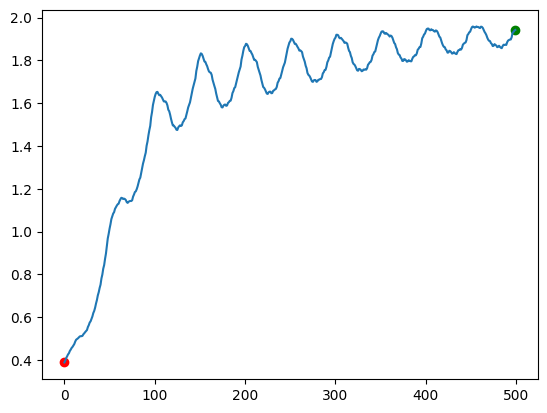

In [33]:
# Setup our parameters
epochs = 10
batch_size = 4
lr = 1e-4

# Run our training loop
sgd = SGD(lr=lr)
training_run(epochs, batch_size, sgd, train_data, valid_data, name="sgd_small")

# Plot the path of the weights over time.
sgd.plot_path()


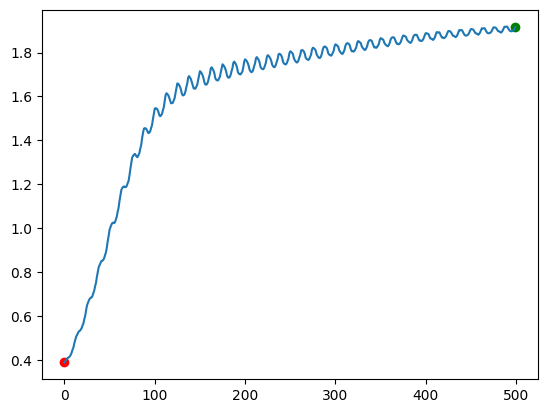

In [34]:
# Setup our parameters
epochs = 40 # higher number of epochs so total steps are equal for comparison purposes
batch_size = 16
lr = 1e-4

# Run our training loop
sgd = SGD(lr=lr)
training_run(epochs, batch_size, sgd, train_data, valid_data, name="sgd_large")
sgd.plot_path()